## Financial Analysis of Hydrogen Financing Using PyPSA-Earth

This notebook loads a solved PyPSA-Earth network (stored as a `.nc` file) and analyses the **hydrogen financing** results.  
The code automatically searches and selects a network to analyse in the <results> folders based on the scenario configuration in `config.yaml`.

- `<results_dir>/<run_name>/networks/` for electricity-only runs  
- `<results_dir>/<sector_name>/postnetworks/` for sector-coupled runs

This notebook then utilizes the PyPSA-Earth framework to analyze the financial aspects of hydrogen within a given network (.nc) file. The analysis includes detailed calculations and visualizations of:

- Hydrogen Capital Expenditures (CAPEX)
- Hydrogen Operational Expenditures (OPEX)
- Hydrogen Supply
- Hydrogen Revenue
- Levelized Cost of Hydrogen (LCOH)

By examining these financial metrics, insights into the economic feasibility and cost structure of hydrogen production in the modeled network are provided.

Sources: 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the hydrogen financing information.
* Configuration file (.yaml) with H2 Electrolysis color

## Import packages

In [1]:
import yaml
import pypsa
import matplotlib.pyplot as plt
import os
import sys
import glob
import logging

## Settings

### Set project root

In [2]:
if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")

PARENT = os.path.realpath("pypsa-earth") + os.sep

### Load configuration

In [3]:
with open(os.path.join(PARENT, "config.yaml"), "r") as f:
    cfg = yaml.safe_load(f)

run = cfg.get("run", {}) or {}
scen = cfg.get("scenario", {}) or {}
costs = cfg.get("costs", {}) or {}
expo = cfg.get("export", {}) or {}

results_dir = (cfg.get("results_dir", "results/") or "results/").strip("/") + "/"

### Directory definitions

In [4]:
RDIR = (run.get("name") or "").strip()
RDIR = (RDIR + "/") if RDIR else ""

SECDIR = (run.get("sector_name") or "").strip()
SECDIR = (SECDIR + "/") if SECDIR else ""

elec_dir = os.path.join(PARENT, results_dir, RDIR, "networks")
sector_post_dir = os.path.join(PARENT, results_dir, SECDIR, "postnetworks")
sector_pre_dir = os.path.join(PARENT, results_dir, SECDIR, "prenetworks")

### Wildcard helper

In [5]:
def pick(val, allow_empty=False):
    """
    Return single value if exactly one is given.
    Return '*' if multiple values or empty (unless allow_empty=True).
    """
    if val is None:
        return "*"
    if isinstance(val, (list, tuple)):
        if len(val) == 1:
            s = "" if val[0] is None else str(val[0])
            return s if (allow_empty or s != "") else "*"
        return "*"
    s = "" if val is None else str(val)
    return s if (allow_empty or s != "") else "*"

### Build wildcard segments

In [6]:
simpl = pick(scen.get("simpl", [""]), allow_empty=True)
clusters = pick(scen.get("clusters"))
ll = pick(scen.get("ll"))
opts = pick(scen.get("opts"))
sopts = pick(scen.get("sopts", [""]), allow_empty=True)
plan = pick(scen.get("planning_horizons"))
dr = pick(costs.get("discountrate"))
demand = pick(scen.get("demand"))

h2_raw = pick(expo.get("h2export"))
h2 = (h2_raw + "export") if h2_raw != "*" else "*export"

### Pattern builders

In [7]:
def post_pattern(include_sopts=True):
    core = f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}"
    tail = f"_{sopts}" if (include_sopts and sopts not in ("",)) else ""
    return os.path.join(sector_post_dir, f"{core}{tail}_{plan}_{dr}_{demand}_{h2}.nc")

def pre_patterns(include_sopts=True):
    core = f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}"
    tail = f"_{sopts}" if (include_sopts and sopts not in ("",)) else ""
    with_export = os.path.join(sector_pre_dir, f"{core}{tail}_{plan}_{dr}_{demand}_{h2}.nc")
    no_export = os.path.join(sector_pre_dir, f"{core}{tail}_{plan}_{dr}_{demand}.nc")
    return [with_export, no_export]

patterns = [
    post_pattern(include_sopts=True),
    post_pattern(include_sopts=False),
    *pre_patterns(include_sopts=True),
    *pre_patterns(include_sopts=False),
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}.nc"),
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}_*.nc"),
]

### Find networks

In [8]:
all_matches = []
for pat in patterns:
    all_matches.extend(glob.glob(pat))

# remove duplicates
all_matches = sorted(set(all_matches), key=os.path.getmtime)

if not all_matches:
    recent = sorted(
        glob.glob(os.path.join(PARENT, results_dir, "**", "*.nc"), recursive=True),
        key=os.path.getmtime
    )[-20:]
    recent_txt = "\n".join(os.path.relpath(p, PARENT) for p in recent) or "(none)"
    raise FileNotFoundError(
        "No network matched.\n"
        "Here are the last few .nc files under results/:\n"
        f"{recent_txt}"
    )

print("Found networks:")
for m in all_matches:
    print("-", os.path.relpath(m, PARENT))

Found networks:
- results/postnetworks/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc


### Network Setup

In [9]:
logging.getLogger("pypsa.io").setLevel(logging.ERROR) # ignore warnings

chosen = all_matches[-1]  # choose newest one
print("\nOpening newest match:", os.path.relpath(chosen, PARENT), "\n")
n = pypsa.Network(chosen)
statistics = n.statistics()
hydrogen_color = cfg["plotting"]["tech_colors"]["high-temp electrolysis"]


Opening newest match: results/postnetworks/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc 



### Basic Ideas

In [10]:
def plot_metric_share(statistics, metric, total_metric, label, title, unit):
    """
    Plot the share of a specific metric (e.g., CAPEX, OPEX, Supply, Revenue) for hydrogen as a pie chart.
    
    Parameters:
        statistics (pd.DataFrame): DataFrame containing metric information.
        metric (str): Metric type (e.g., 'Capital Expenditure', 'Operational Expenditure', 'Supply', 'Revenue').
        total_metric (float): Total value of the metric for all components (e.g., in Mio. €, TWh).
        label (str): Label for hydrogen factor in the chart.
        title (str): Title for the pie chart.
        unit (str): Unit of the metric for display (e.g., 'Mio. €', 'TWh').
    """
    # Calculate hydrogen metric
    h2_metric = (statistics.loc["Link", "H2 Electrolysis"][metric] / 1e6).round(2)
    other_metric = (total_metric - h2_metric).round(2)

    # Print metric details
    print(f"H2 {label} is: {h2_metric} {unit}")
    print(f"Other {label} is: {other_metric} {unit}")
    print(f"Total {label} is: {total_metric} {unit}")

    # Prepare data for the pie chart
    values = [h2_metric, other_metric]
    labels = [f"H2 {label}", f"Other {label}"]
    colors = [hydrogen_color, "lightgrey"]

    # Plot the pie chart
    plt.figure(figsize=(6, 6))  # Set figure size
    plt.pie(values, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(title)
    plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 0.8))
    plt.axis('equal')  # Ensures the pie chart is circular
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


In [11]:
h2_electrolysis = (
        statistics.loc["Link", "H2 Electrolysis"]
)
h2_electrolysis

Optimal Capacity           6.158121e+03
Installed Capacity         0.000000e+00
Supply                     1.643287e+07
Withdrawal                 2.347553e+07
Energy Balance            -7.042659e+06
Transmission               0.000000e+00
Capacity Factor            4.351741e-01
Curtailment                0.000000e+00
Capital Expenditure        2.104466e+08
Operational Expenditure    2.184250e+05
Revenue                    2.106629e+08
Market Value               1.281961e+01
Name: (Link, H2 Electrolysis), dtype: float64

H2 CAPEX is: 210.45 Mio. €
Other CAPEX is: 11.32 Mio. €
Total CAPEX is: 221.77 Mio. €


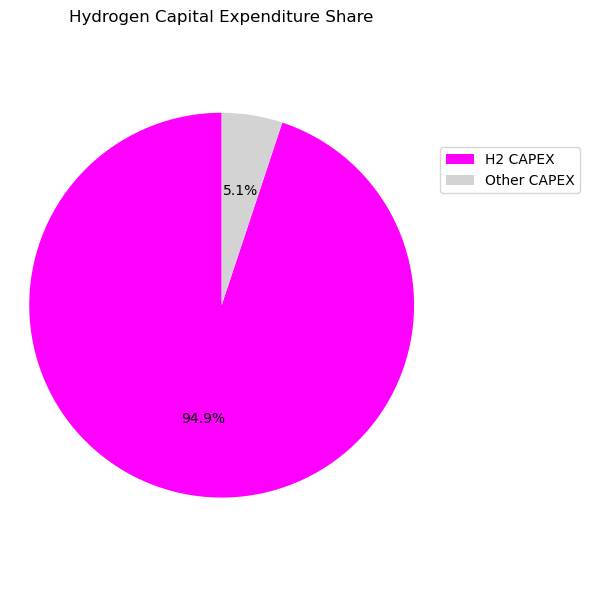

In [12]:
# CAPEX Example
total_capex = (n.statistics.capex(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Capital Expenditure",
    total_metric=total_capex,
    label="CAPEX",
    title="Hydrogen Capital Expenditure Share",
    unit="Mio. €",
)

H2 OPEX is: 0.22 Mio. €
Other OPEX is: 4.92 Mio. €
Total OPEX is: 5.14 Mio. €


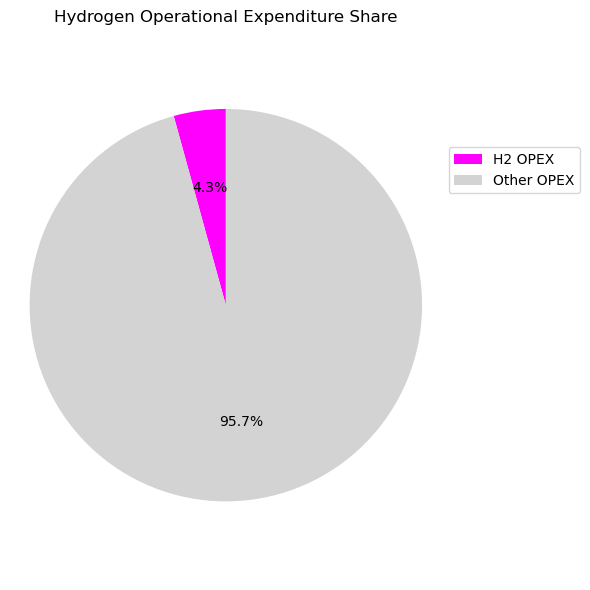

In [13]:
total_opex = (n.statistics.opex(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Operational Expenditure",
    total_metric=total_opex,
    label="OPEX",
    title="Hydrogen Operational Expenditure Share",
    unit="Mio. €",
)


H2 Supply is: 16.43 TWh
Other Supply is: 70.86 TWh
Total Supply is: 87.29 TWh


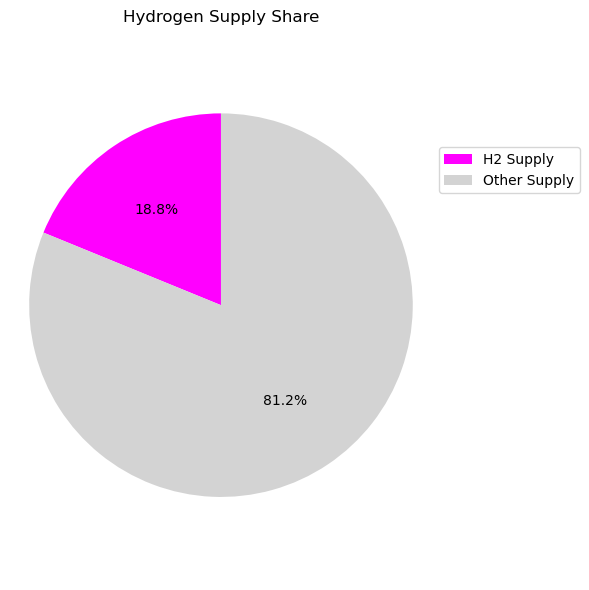

In [14]:
total_supply = (n.statistics.supply(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Supply",
    total_metric=total_supply,
    label="Supply",
    title="Hydrogen Supply Share",
    unit="TWh",
)

H2 Revenue is: 210.66 Mio. €
Other Revenue is: 16.72 Mio. €
Total Revenue is: 227.38 Mio. €


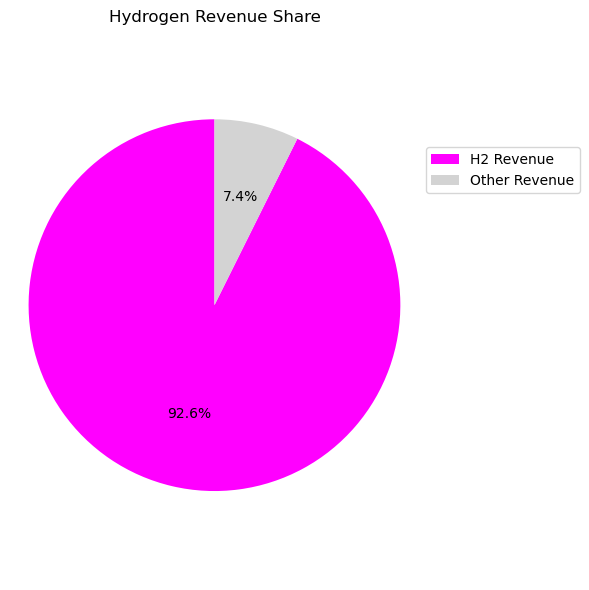

In [15]:
total_revenue = (n.statistics.revenue(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Revenue",
    total_metric=total_revenue,
    label="Revenue",
    title="Hydrogen Revenue Share",
    unit="Mio. €",
)

In [16]:
h2_capex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Capital Expenditure"]
        .round(2)
        / 1e6
) 

h2_opex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Operational Expenditure"]
        .round(2)
        / 1e6
) 

h2_supply = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Supply"]
        .round(2)
        / 1e6
) 

# Determine expense on electricity for hydrogen production
buses_sel = n.buses[n.buses.carrier == "AC"].index
prices = n.buses_t.marginal_price[buses_sel]
demand = n.links_t.p1[n.links[n.links.carrier == "H2 Electrolysis"].index]

demand.columns = (
    prices.columns
)  # Adjust column names to match prices for multiplication

e_cost = (
    (prices * demand).sum().sum()
    * (-1)
    * n.snapshot_weightings.generators[0]
    / 1e6
)  # in Mio. €

lcoh_compo = ((h2_opex + h2_opex + e_cost) / h2_supply).round(2)  # in €/MWh
print(f"Levelized Cost of Hydrogen (LCOH) is: {lcoh_compo} €/MWh")

Levelized Cost of Hydrogen (LCOH) is: 28.01 €/MWh


/tmp/ipykernel_80312/3728563782.py:34: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

